# Convolutional Neural Network

In this notebook you will compare the performance of a Fully Connected vs simple Convolutional Neural Networks.

In [1]:
import os
import time
import tqdm
import torch
import functools
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 523 kB 4.3 MB/s 
     |████████████████████████████████| 132 kB 53.1 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |████████████████████████████████| 829 kB 45.5 MB/s 
     |████████████████████████████████| 329 kB 45.9 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 192 kB 48.9 MB/s 
     |████████████████████████████████| 160 kB 47.7 MB/s 
     |████████████████████████████████| 271 kB 52.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9ac39f3813b534d96ce4729c712eb2e2f204f21a351083b5fd0d7811f87606b3
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [3]:
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.utilities.seed import seed_everything

seed_everything(123)

Global seed set to 123


123

# Start

#### Download dataset

In this notebook you are going to work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). `Fashion-MNIST` is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


In [4]:
DATA_DIR = './data'

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms


class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir=DATA_DIR):
        super().__init__()
        
        # Hardcode some dataset specific attributes
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.5,), (0.5,)),
                                             ])
    
        # Set our init args as class attributes
        self.data_dir = data_dir
    
    def prepare_data(self):
        # download
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            data_full = datasets.FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = torch.utils.data.random_split(data_full, [50000, 10000])            

        # Assign test dataset for use in dataloader
        if stage == 'test' or stage is None:
            self.fmnist_test = datasets.FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_train, batch_size=32,
                                           shuffle=True, num_workers=2)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_val, batch_size=32,
                                           shuffle=False, num_workers=2)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_test, batch_size=32,
                                           shuffle=False, num_workers=2)

In [6]:
label2description_list = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


fmnist_datamodule = FashionMNISTDataModule()
fmnist_datamodule.prepare_data()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Lets display a few of dataset items:

In [7]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

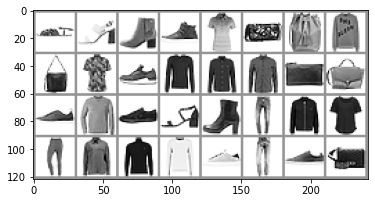

In [8]:
fmnist_datamodule.setup('fit')

dataiter = iter(fmnist_datamodule.train_dataloader())
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

#### Checking for available GPU device.

In [9]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])


if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(),)
    print('Selected %s' % (device,))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:0


# Building a baseline FC-network

## Network

Let's start with a simple baseline Fully Connected network to compare with:

In [18]:
class FashionMNISTModelFC(pl.LightningModule):

    def __init__(self, learning_rate=0.01):

        super(FashionMNISTModelFC, self).__init__()
        self.save_hyperparameters()

        # Set our init args as class attributes
        self.hparams.learning_rate = learning_rate

        # Define PyTorch model layers
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    

By using the `Trainer` you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [19]:
# Init out datamodule
dm = FashionMNISTDataModule()
dm.prepare_data()

# Init our model
fmnist_model = FashionMNISTModelFC().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Testing

To test a model, call `trainer.test(model)`.

Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically test using the best saved checkpoint (conditioned on val_loss).

In [20]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=9-step=15629.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_2/chec

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8687999844551086, 'val_loss': 0.3665005564689636}
--------------------------------------------------------------------------------


[{'val_acc': 0.8687999844551086, 'val_loss': 0.3665005564689636}]

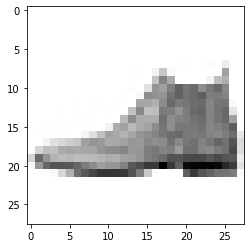

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.873
	Sneaker: 0.065
	Sandal: 0.059


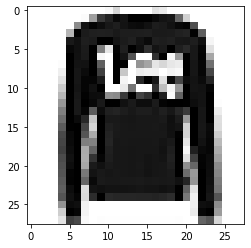

True label: Pullover
Top 3 predictions:
	Pullover: 0.997
	Shirt: 0.002
	Coat: 0.001


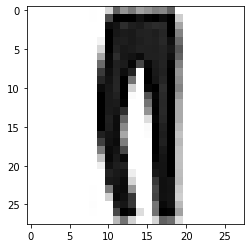

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Pullover: 0.000


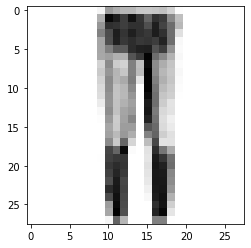

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


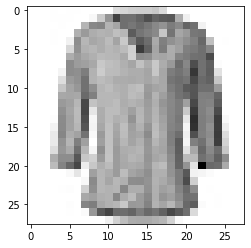

True label: Shirt
Top 3 predictions:
	Shirt: 0.743
	T-shirt/top: 0.171
	Pullover: 0.061


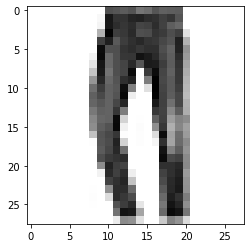

True label: Trouser
Top 3 predictions:
	Trouser: 0.996
	T-shirt/top: 0.003
	Pullover: 0.000


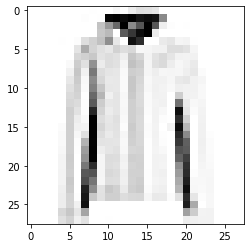

True label: Coat
Top 3 predictions:
	Coat: 0.968
	Shirt: 0.020
	Pullover: 0.010


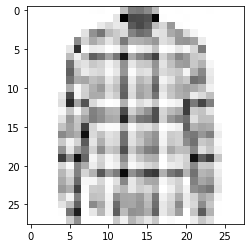

True label: Shirt
Top 3 predictions:
	Shirt: 0.957
	Coat: 0.036
	Pullover: 0.007


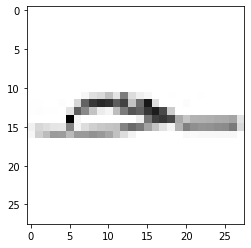

True label: Sandal
Top 3 predictions:
	Sandal: 0.965
	Sneaker: 0.020
	Pullover: 0.004


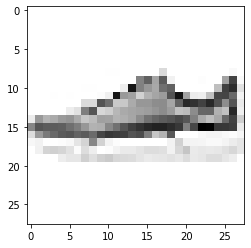

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.988
	Sandal: 0.010
	Bag: 0.001


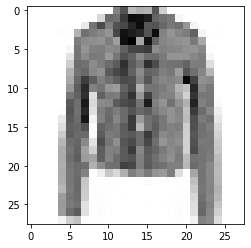

True label: Coat
Top 3 predictions:
	Coat: 0.756
	Pullover: 0.224
	Shirt: 0.017


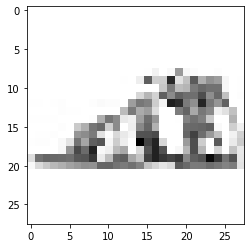

True label: Sandal
Top 3 predictions:
	Sandal: 0.954
	Sneaker: 0.023
	Ankle boot: 0.012


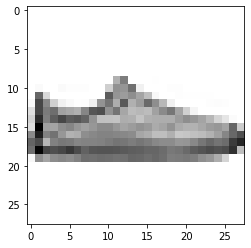

True label: Sneaker
Top 3 predictions:
	Sandal: 0.475
	Sneaker: 0.436
	Bag: 0.080


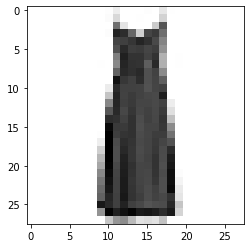

True label: Dress
Top 3 predictions:
	Dress: 0.990
	Trouser: 0.009
	Bag: 0.000


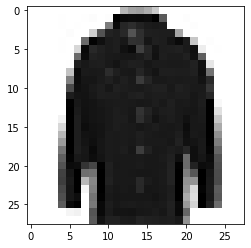

True label: Coat
Top 3 predictions:
	Coat: 0.710
	Pullover: 0.274
	Shirt: 0.009


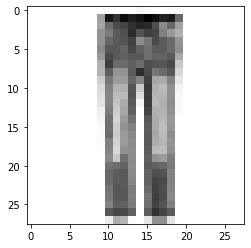

True label: Trouser
Top 3 predictions:
	Trouser: 0.998
	Dress: 0.002
	T-shirt/top: 0.000


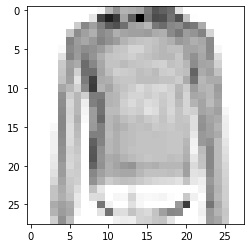

True label: Pullover
Top 3 predictions:
	Pullover: 0.979
	T-shirt/top: 0.010
	Shirt: 0.007


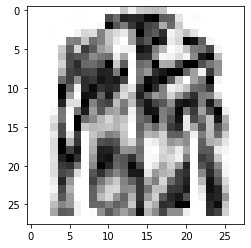

True label: Coat
Top 3 predictions:
	Pullover: 0.887
	Coat: 0.091
	Shirt: 0.019


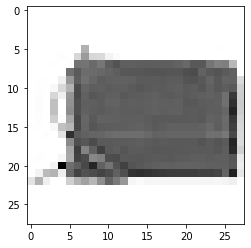

True label: Bag
Top 3 predictions:
	Bag: 0.999
	T-shirt/top: 0.000
	Coat: 0.000


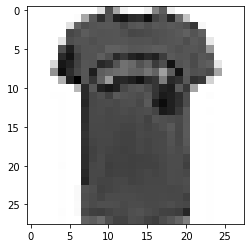

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.976
	Shirt: 0.021
	Pullover: 0.002


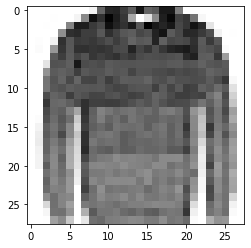

True label: Pullover
Top 3 predictions:
	Pullover: 0.726
	T-shirt/top: 0.150
	Shirt: 0.050


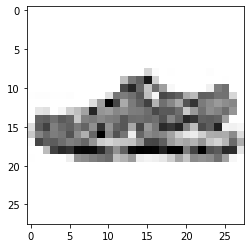

True label: Sandal
Top 3 predictions:
	Sandal: 0.717
	Sneaker: 0.277
	Bag: 0.003


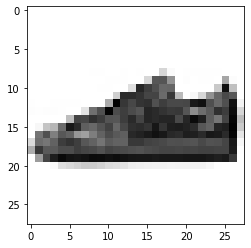

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.990
	Sandal: 0.005
	Ankle boot: 0.004


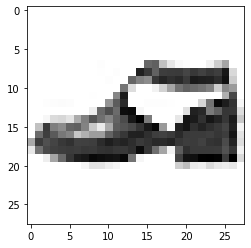

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.670
	Sneaker: 0.212
	Ankle boot: 0.114


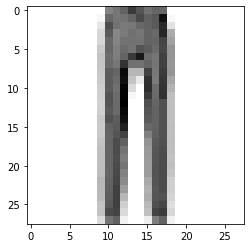

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Pullover: 0.000


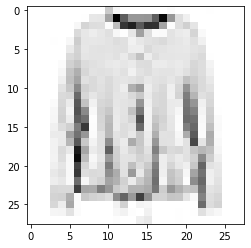

True label: Coat
Top 3 predictions:
	Pullover: 0.827
	Coat: 0.140
	Shirt: 0.028


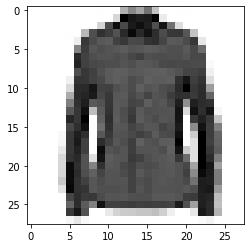

True label: Shirt
Top 3 predictions:
	Shirt: 0.866
	Coat: 0.109
	Pullover: 0.023


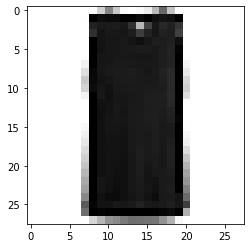

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.762
	Shirt: 0.134
	Dress: 0.076


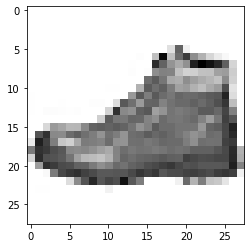

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.938
	Sneaker: 0.060
	Sandal: 0.002


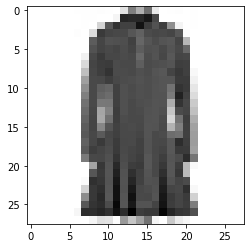

True label: Dress
Top 3 predictions:
	Dress: 0.459
	Coat: 0.262
	Shirt: 0.195


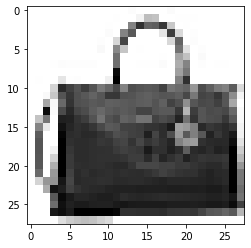

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


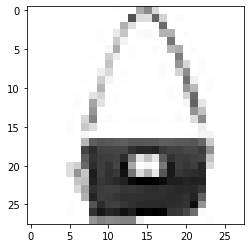

True label: Bag
Top 3 predictions:
	Bag: 0.984
	Dress: 0.012
	Pullover: 0.002


In [21]:
from scipy.special import softmax

# helper function to show an image
def matplotlib_imshow_apply_model(img, true_label, prediction):
    plt.imshow(img, cmap="Greys")
    plt.show()
    print(f'True label: {label2description_list[true_label]}')
    print('Top 3 predictions:')
    probs = softmax(prediction.cpu().detach().numpy(), axis=None)
    top3_probs = np.argsort(probs)[-3:]
    for label in top3_probs[::-1]:
        print(f'\t{label2description_list[label]}: {probs[label]:.3f}')

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Building a baseline CNN-network

## Network

Let's change our network to the CNN:

In [14]:
class FashionMNISTModelCNN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.01):

        super(FashionMNISTModelCNN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.fc1 = nn.Linear(28*28*4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
# Init our model
fmnist_model = FashionMNISTModelCNN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Testing

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=9-step=15629.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_1/chec

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8765000104904175, 'val_loss': 0.33833277225494385}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


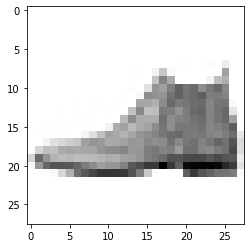

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.993
	Sneaker: 0.006
	Sandal: 0.001


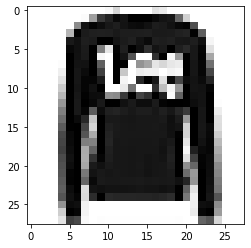

True label: Pullover
Top 3 predictions:
	Pullover: 0.985
	Shirt: 0.011
	Coat: 0.003


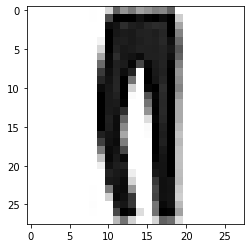

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Dress: 0.000


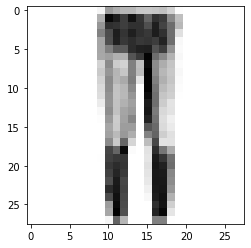

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


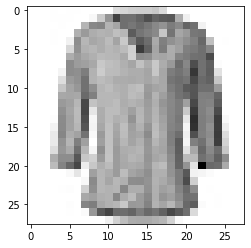

True label: Shirt
Top 3 predictions:
	Shirt: 0.867
	T-shirt/top: 0.077
	Pullover: 0.036


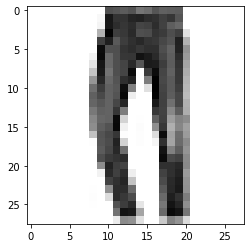

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Coat: 0.000
	T-shirt/top: 0.000


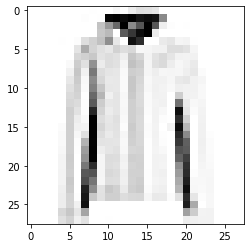

True label: Coat
Top 3 predictions:
	Coat: 0.984
	Shirt: 0.010
	Pullover: 0.005


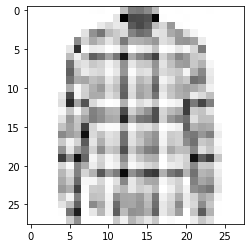

True label: Shirt
Top 3 predictions:
	Shirt: 0.986
	Coat: 0.013
	Pullover: 0.001


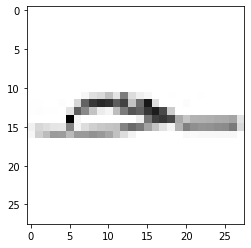

True label: Sandal
Top 3 predictions:
	Sandal: 0.933
	Sneaker: 0.038
	Bag: 0.014


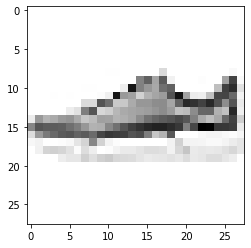

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.995
	Ankle boot: 0.002
	Sandal: 0.002


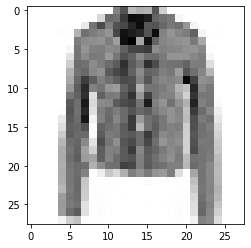

True label: Coat
Top 3 predictions:
	Coat: 0.872
	Pullover: 0.106
	Shirt: 0.022


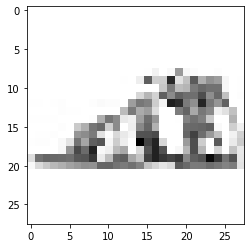

True label: Sandal
Top 3 predictions:
	Sandal: 0.992
	Ankle boot: 0.004
	Sneaker: 0.003


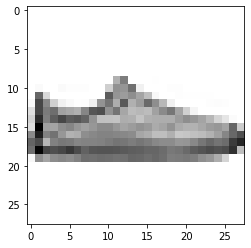

True label: Sneaker
Top 3 predictions:
	Sandal: 0.740
	Bag: 0.151
	Sneaker: 0.107


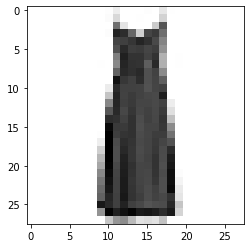

True label: Dress
Top 3 predictions:
	Dress: 0.978
	Trouser: 0.020
	T-shirt/top: 0.001


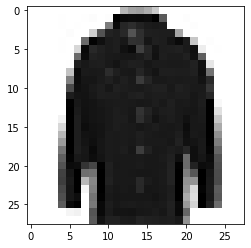

True label: Coat
Top 3 predictions:
	Coat: 0.906
	Pullover: 0.078
	Shirt: 0.012


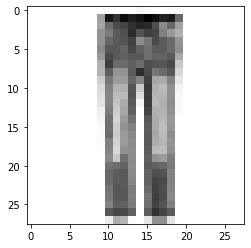

True label: Trouser
Top 3 predictions:
	Trouser: 0.997
	Dress: 0.002
	T-shirt/top: 0.000


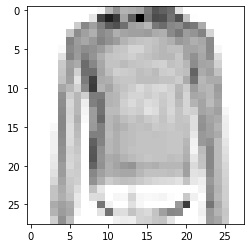

True label: Pullover
Top 3 predictions:
	Pullover: 0.909
	Shirt: 0.071
	T-shirt/top: 0.009


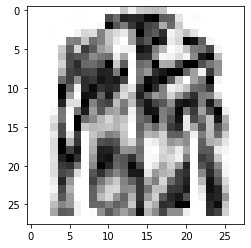

True label: Coat
Top 3 predictions:
	Pullover: 0.472
	Coat: 0.426
	Shirt: 0.099


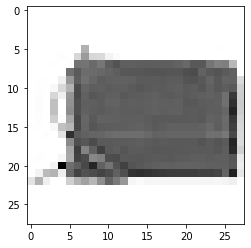

True label: Bag
Top 3 predictions:
	Bag: 0.997
	T-shirt/top: 0.001
	Shirt: 0.001


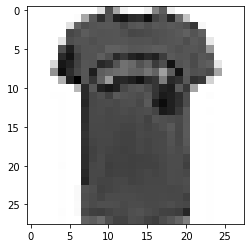

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.981
	Shirt: 0.017
	Dress: 0.001


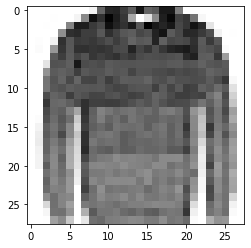

True label: Pullover
Top 3 predictions:
	Pullover: 0.902
	T-shirt/top: 0.035
	Shirt: 0.027


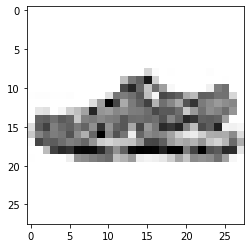

True label: Sandal
Top 3 predictions:
	Sandal: 0.894
	Sneaker: 0.092
	Ankle boot: 0.012


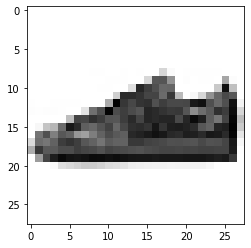

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.958
	Ankle boot: 0.037
	Sandal: 0.003


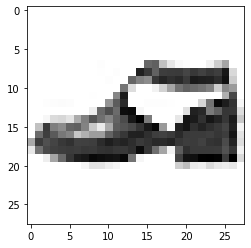

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.880
	Ankle boot: 0.092
	Sneaker: 0.027


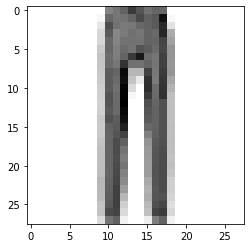

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


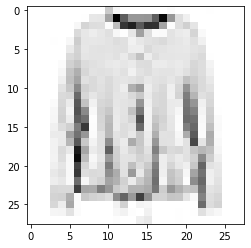

True label: Coat
Top 3 predictions:
	Pullover: 0.526
	Shirt: 0.313
	Coat: 0.156


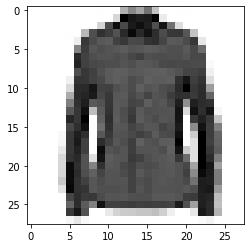

True label: Shirt
Top 3 predictions:
	Shirt: 0.851
	Coat: 0.146
	Pullover: 0.002


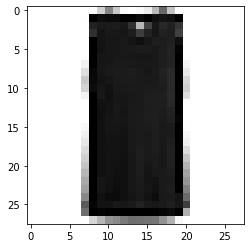

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.905
	Shirt: 0.074
	Dress: 0.018


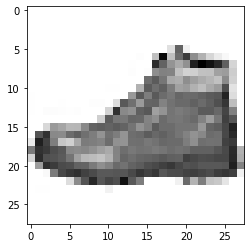

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.995
	Sneaker: 0.004
	Sandal: 0.000


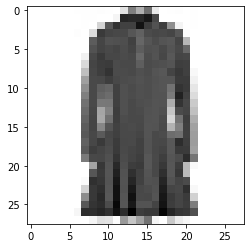

True label: Dress
Top 3 predictions:
	Coat: 0.508
	Dress: 0.244
	Shirt: 0.154


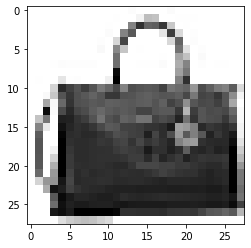

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


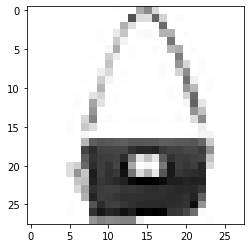

True label: Bag
Top 3 predictions:
	Bag: 0.994
	T-shirt/top: 0.003
	Dress: 0.002


In [16]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

## Result

We used only one convolutional layer, and we got better accuracy obtained using a fully connected network (although the parameters of the convolutional network were less than that of a fully connected network - **315K** versus **454K**) 

## Task 1

Now it's your turn. Impove your CNN network to achive **0.895 accuracy** on validation.

1. add one more CNN layer (with ReLU);
2. increate the number of out channels in the second CNN layer up to 16 *(so: 4 in and 16 out)*; 
3. add a fully connected layer. You should have three consecutive FC-layers like:
  * nn.Linear(12544, 1024)
  * nn.Linear(1024, 100)
  * nn.Linear(100, 10)

In [24]:
class MySuperFashionMNISTModelCNN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.01):

        super(MySuperFashionMNISTModelCNN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.fc1 = nn.Linear(12544, 1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # your code here
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


The number of learning parameters has increased significantly, so we will increase the number of training steps to 20:

In [25]:
# Init our model
fmnist_model = MySuperFashionMNISTModelCNN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=20, progress_bar_refresh_rate=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Task 1 testing

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=19-step=31259.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_4/che

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8927000164985657, 'val_loss': 0.30939781665802}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


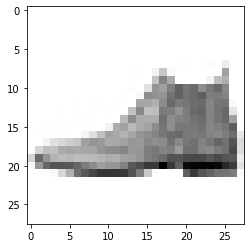

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.999
	Sneaker: 0.001
	Sandal: 0.000


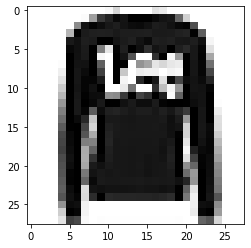

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	Coat: 0.000
	T-shirt/top: 0.000


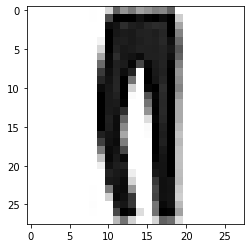

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Coat: 0.000


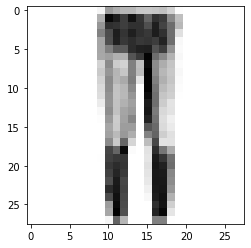

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


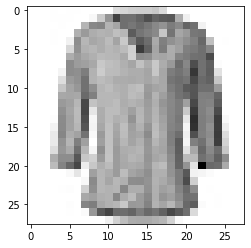

True label: Shirt
Top 3 predictions:
	Shirt: 0.868
	T-shirt/top: 0.127
	Pullover: 0.005


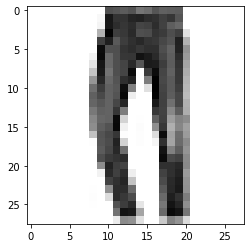

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Dress: 0.000


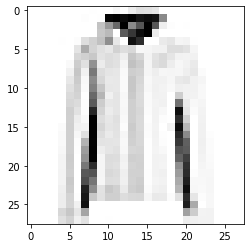

True label: Coat
Top 3 predictions:
	Coat: 0.984
	Pullover: 0.016
	Shirt: 0.000


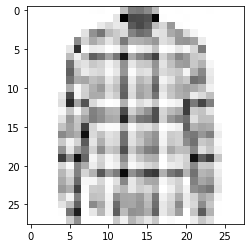

True label: Shirt
Top 3 predictions:
	Shirt: 0.999
	Coat: 0.001
	Pullover: 0.000


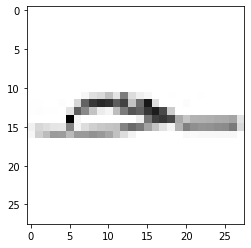

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Pullover: 0.000


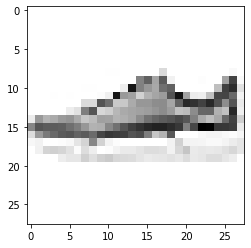

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Sandal: 0.000
	Bag: 0.000


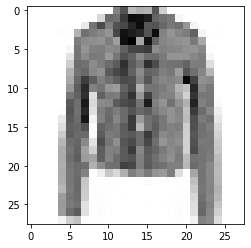

True label: Coat
Top 3 predictions:
	Coat: 0.948
	Pullover: 0.049
	Shirt: 0.003


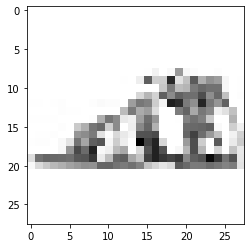

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Shirt: 0.000


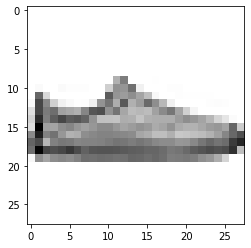

True label: Sneaker
Top 3 predictions:
	Sandal: 0.662
	Sneaker: 0.272
	Bag: 0.066


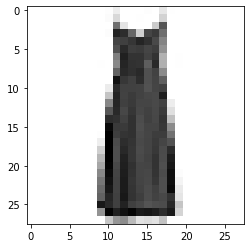

True label: Dress
Top 3 predictions:
	Dress: 0.999
	Trouser: 0.001
	T-shirt/top: 0.000


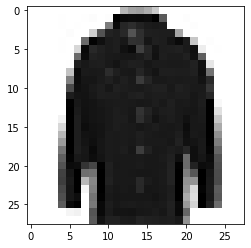

True label: Coat
Top 3 predictions:
	Coat: 0.823
	Pullover: 0.176
	Shirt: 0.000


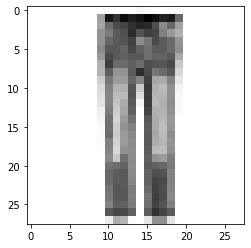

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


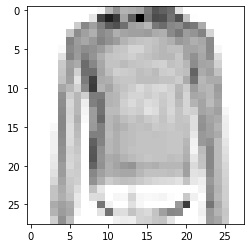

True label: Pullover
Top 3 predictions:
	Pullover: 0.999
	Shirt: 0.001
	T-shirt/top: 0.000


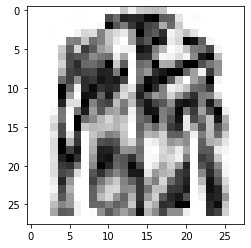

True label: Coat
Top 3 predictions:
	Pullover: 0.710
	Coat: 0.286
	Shirt: 0.004


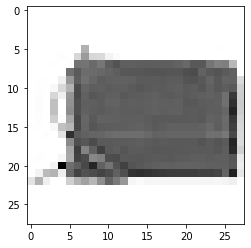

True label: Bag
Top 3 predictions:
	Bag: 1.000
	T-shirt/top: 0.000
	Sandal: 0.000


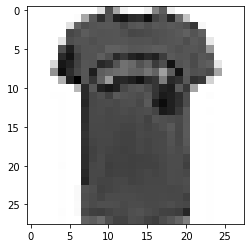

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.976
	Shirt: 0.012
	Pullover: 0.012


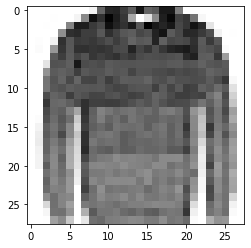

True label: Pullover
Top 3 predictions:
	Pullover: 0.996
	T-shirt/top: 0.003
	Shirt: 0.001


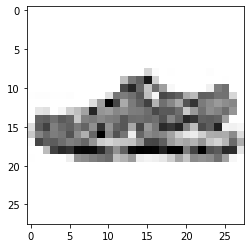

True label: Sandal
Top 3 predictions:
	Sandal: 0.970
	Sneaker: 0.030
	Ankle boot: 0.000


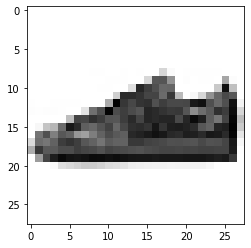

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.999
	Sandal: 0.000
	Ankle boot: 0.000


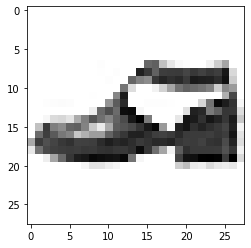

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.999
	Sneaker: 0.001
	Ankle boot: 0.000


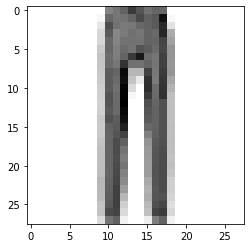

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


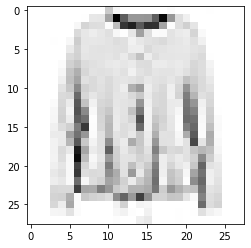

True label: Coat
Top 3 predictions:
	Pullover: 0.747
	Shirt: 0.213
	Coat: 0.039


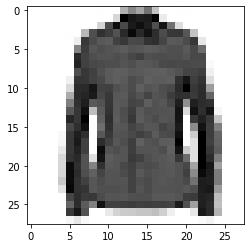

True label: Shirt
Top 3 predictions:
	Shirt: 0.958
	Coat: 0.037
	Pullover: 0.005


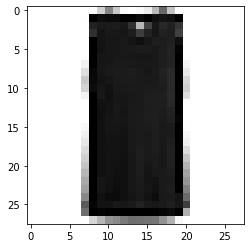

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.938
	Shirt: 0.059
	Dress: 0.002


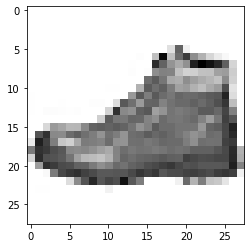

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.996
	Sneaker: 0.004
	Sandal: 0.000


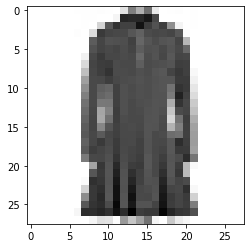

True label: Dress
Top 3 predictions:
	Coat: 0.481
	Dress: 0.250
	Shirt: 0.204


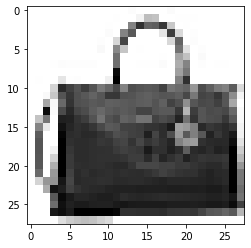

True label: Bag
Top 3 predictions:
	Bag: 1.000
	T-shirt/top: 0.000
	Sandal: 0.000


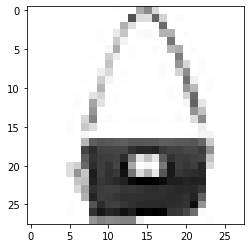

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Dress: 0.000
	Coat: 0.000


In [26]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Add Pooling, Batchnorm and Dropout

## Network

Let's add pooling, batchnorm and dropout layers. Adding a batchnorm layer allows us to increase the learning rate without losing stability. Take, for example, the learning rate 0.03 instead 0.01 (you can independently check what happens if you increase the learning rate without using a batchnorm layer).

In [27]:
class FashionMNISTModelCNNPoolingBN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.03):

        super(FashionMNISTModelCNNPoolingBN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv1_bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(784, 100)
        self.fc1_bn = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = x.flatten(1)
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [28]:
# Init our model
fmnist_model = FashionMNISTModelCNNPoolingBN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10, progress_bar_refresh_rate=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Testing

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_5/checkpoints/epoch=9-step=15629.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_5/chec

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.9006999731063843, 'val_loss': 0.27008122205734253}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


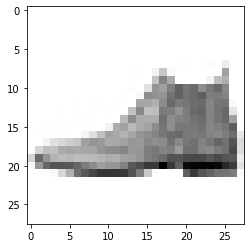

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sneaker: 0.000
	Sandal: 0.000


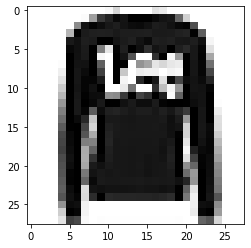

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	T-shirt/top: 0.000
	Coat: 0.000


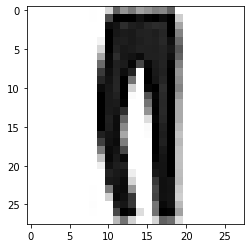

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Bag: 0.000


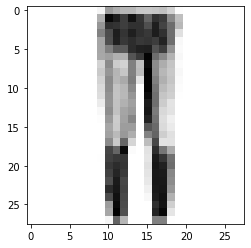

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


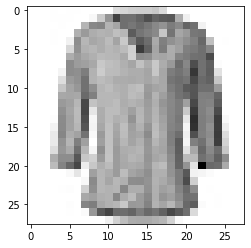

True label: Shirt
Top 3 predictions:
	Shirt: 0.524
	T-shirt/top: 0.416
	Pullover: 0.030


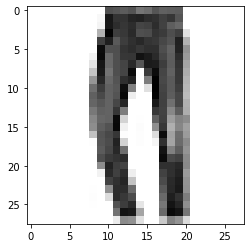

True label: Trouser
Top 3 predictions:
	Trouser: 0.998
	T-shirt/top: 0.002
	Dress: 0.000


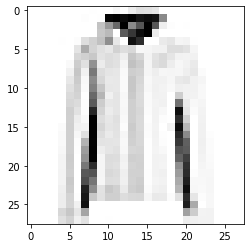

True label: Coat
Top 3 predictions:
	Coat: 0.989
	Pullover: 0.009
	Shirt: 0.001


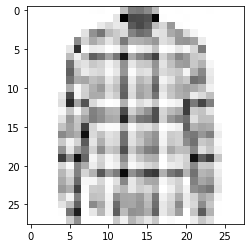

True label: Shirt
Top 3 predictions:
	Shirt: 0.971
	Coat: 0.015
	Pullover: 0.013


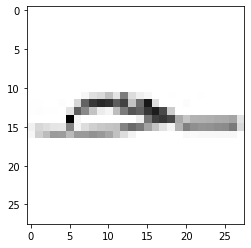

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	T-shirt/top: 0.000


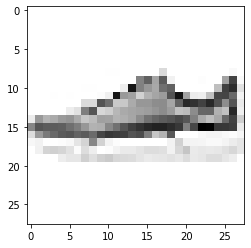

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Sandal: 0.000
	Dress: 0.000


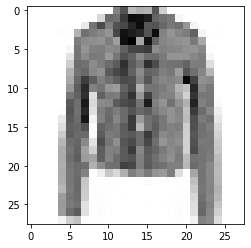

True label: Coat
Top 3 predictions:
	Coat: 0.982
	Pullover: 0.011
	Shirt: 0.006


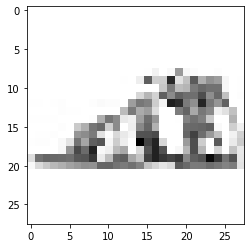

True label: Sandal
Top 3 predictions:
	Sandal: 0.971
	Sneaker: 0.026
	Ankle boot: 0.002


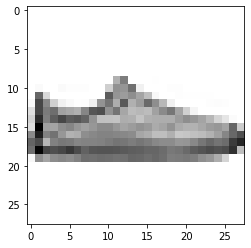

True label: Sneaker
Top 3 predictions:
	Bag: 0.538
	Sandal: 0.207
	Sneaker: 0.122


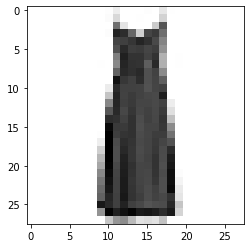

True label: Dress
Top 3 predictions:
	Dress: 0.999
	T-shirt/top: 0.001
	Pullover: 0.000


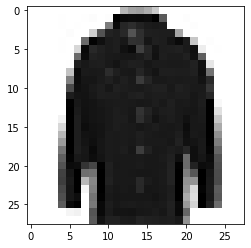

True label: Coat
Top 3 predictions:
	Pullover: 0.510
	Coat: 0.485
	Shirt: 0.003


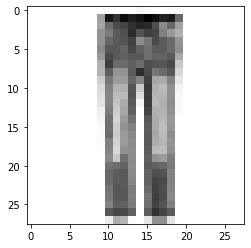

True label: Trouser
Top 3 predictions:
	Trouser: 0.994
	Dress: 0.003
	Coat: 0.002


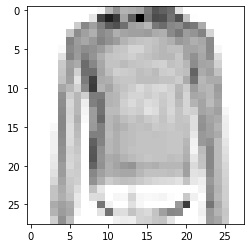

True label: Pullover
Top 3 predictions:
	Pullover: 0.854
	Shirt: 0.131
	T-shirt/top: 0.010


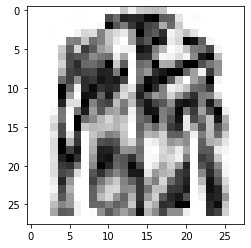

True label: Coat
Top 3 predictions:
	Shirt: 0.486
	Coat: 0.467
	Pullover: 0.038


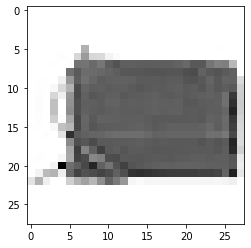

True label: Bag
Top 3 predictions:
	Bag: 0.999
	Pullover: 0.000
	T-shirt/top: 0.000


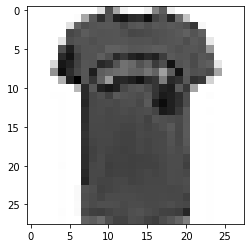

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.994
	Shirt: 0.006
	Dress: 0.000


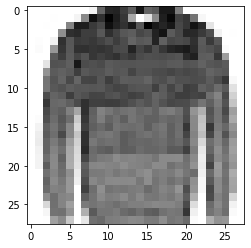

True label: Pullover
Top 3 predictions:
	Pullover: 0.966
	T-shirt/top: 0.018
	Shirt: 0.010


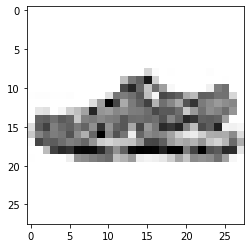

True label: Sandal
Top 3 predictions:
	Sneaker: 0.589
	Sandal: 0.405
	Ankle boot: 0.005


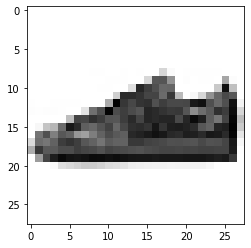

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.997
	Ankle boot: 0.003
	Sandal: 0.000


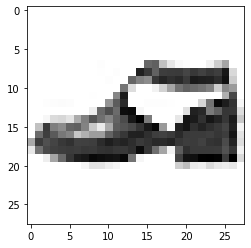

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.985
	Ankle boot: 0.014
	Sneaker: 0.001


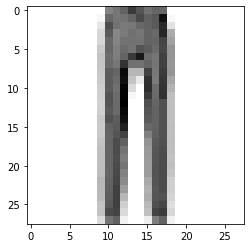

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


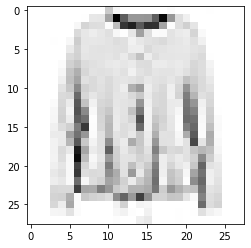

True label: Coat
Top 3 predictions:
	Shirt: 0.530
	Coat: 0.248
	Pullover: 0.219


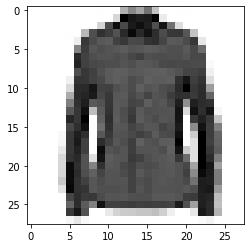

True label: Shirt
Top 3 predictions:
	Shirt: 0.896
	Coat: 0.091
	Pullover: 0.012


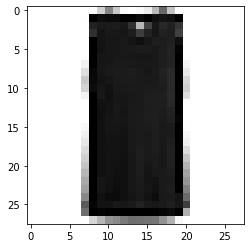

True label: T-shirt/top
Top 3 predictions:
	Shirt: 0.545
	T-shirt/top: 0.439
	Dress: 0.013


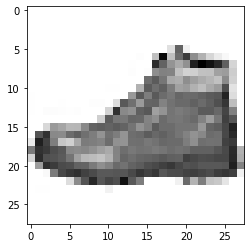

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.996
	Sneaker: 0.004
	Sandal: 0.000


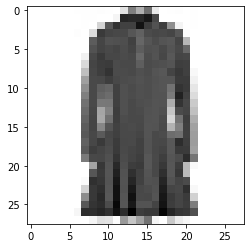

True label: Dress
Top 3 predictions:
	Dress: 0.723
	Coat: 0.185
	Shirt: 0.080


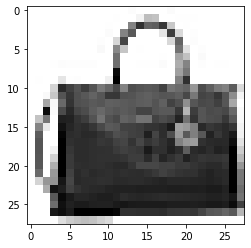

True label: Bag
Top 3 predictions:
	Bag: 1.000
	T-shirt/top: 0.000
	Sneaker: 0.000


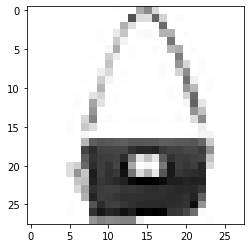

True label: Bag
Top 3 predictions:
	Bag: 0.998
	Dress: 0.002
	Sandal: 0.000


In [29]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

## Result

Admire how more efficient convolutional networks are! We used only one convolutional layer with pooling, batchnorm and dropout. As result, we got much better accuracy obtained using a fully connected network with significantly fewer parameters (**80.8K** versus **454K**).

## Task 2

Now it's your turn again. Impove your CNN network with pooling and batchnorm to achive **0.91 accuracy** on validation.

1. add one more CNN layer with Batchnorm, ReLU and max pooling;
2. add one more FC layer with Batchnorm and ReLU; 
3. add Batchnorm to the penultimate FC-layer;
4. add Dropout layers after Flatten and FC layres (see example above).

Eventually, the network should be look like:

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1            [-1, 4, 28, 28]              40
            Conv2d-2           [-1, 16, 28, 28]             592
       BatchNorm2d-3           [-1, 16, 28, 28]              32
           Dropout-4                 [-1, 3136]               0
            Linear-5                 [-1, 1024]       3,212,288
       BatchNorm1d-6                 [-1, 1024]           2,048
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 100]         102,500
       BatchNorm1d-9                  [-1, 100]             200
          Dropout-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
================================================================
Total params: 3,318,710
Trainable params: 3,318,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 12.66
Estimated Total Size (MB): 12.93
----------------------------------------------------------------
```

In [35]:
class MySuperFashionMNISTModelCNNPoolingBN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.03):

        super(MySuperFashionMNISTModelCNNPoolingBN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(3136, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc2_bn = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.flatten(1)
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


In [36]:
from torchsummary import summary

fmnist_model = MySuperFashionMNISTModelCNNPoolingBN().to(device)
summary(fmnist_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
            Conv2d-2           [-1, 16, 28, 28]             592
       BatchNorm2d-3           [-1, 16, 28, 28]              32
           Dropout-4                 [-1, 3136]               0
            Linear-5                 [-1, 1024]       3,212,288
       BatchNorm1d-6                 [-1, 1024]           2,048
            Linear-7                  [-1, 100]         102,500
       BatchNorm1d-8                  [-1, 100]             200
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 3,318,710
Trainable params: 3,318,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 12.66
Estima

In [37]:
# Init our model
fmnist_model = MySuperFashionMNISTModelCNNPoolingBN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=20, progress_bar_refresh_rate=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


## Task 2 testing

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_6/checkpoints/epoch=19-step=31259.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_6/che

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.9236000180244446, 'val_loss': 0.3085474371910095}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


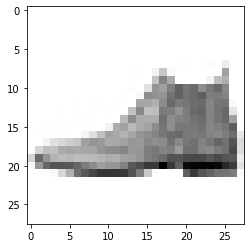

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sneaker: 0.000
	Bag: 0.000


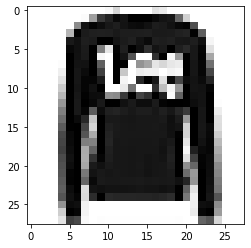

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	T-shirt/top: 0.000
	Shirt: 0.000


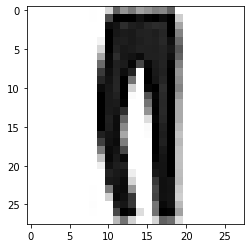

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Ankle boot: 0.000


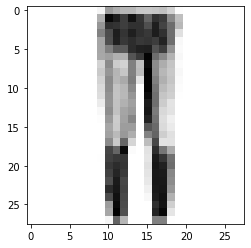

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Ankle boot: 0.000
	Sneaker: 0.000


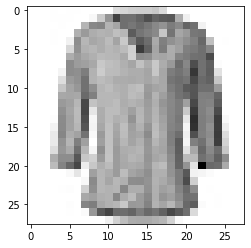

True label: Shirt
Top 3 predictions:
	Shirt: 0.996
	T-shirt/top: 0.004
	Ankle boot: 0.000


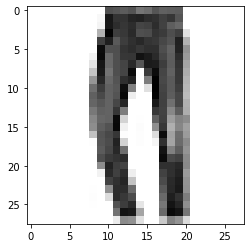

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Ankle boot: 0.000
	Sandal: 0.000


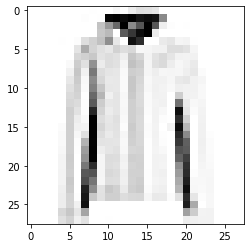

True label: Coat
Top 3 predictions:
	Coat: 0.999
	Pullover: 0.001
	T-shirt/top: 0.000


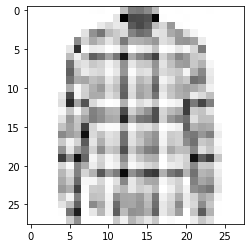

True label: Shirt
Top 3 predictions:
	Shirt: 0.966
	Coat: 0.033
	Bag: 0.000


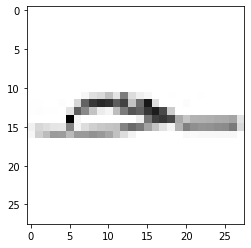

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Bag: 0.000
	Ankle boot: 0.000


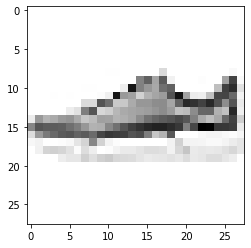

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Sandal: 0.000
	Ankle boot: 0.000


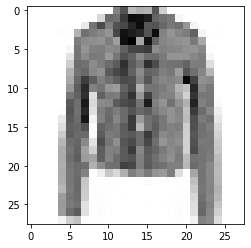

True label: Coat
Top 3 predictions:
	Coat: 1.000
	Pullover: 0.000
	Shirt: 0.000


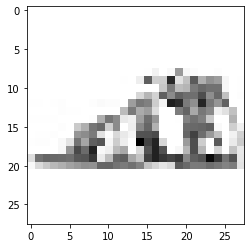

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Ankle boot: 0.000
	Bag: 0.000


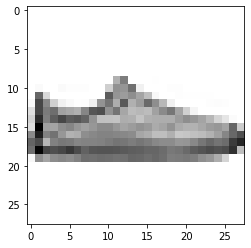

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.978
	Sandal: 0.021
	Bag: 0.001


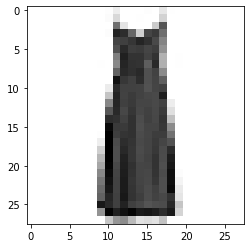

True label: Dress
Top 3 predictions:
	Dress: 1.000
	Ankle boot: 0.000
	T-shirt/top: 0.000


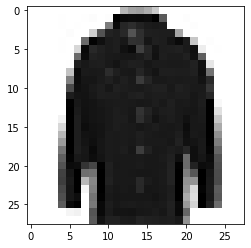

True label: Coat
Top 3 predictions:
	Coat: 0.997
	Ankle boot: 0.002
	Pullover: 0.000


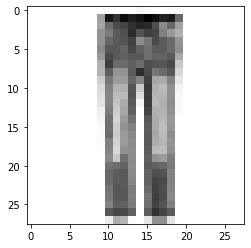

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Ankle boot: 0.000
	Bag: 0.000


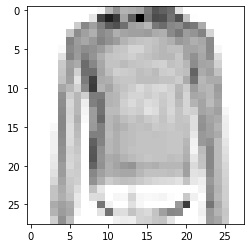

True label: Pullover
Top 3 predictions:
	Shirt: 0.892
	Pullover: 0.105
	T-shirt/top: 0.002


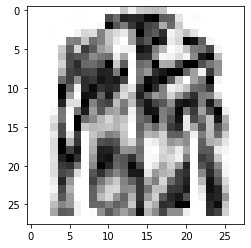

True label: Coat
Top 3 predictions:
	Coat: 0.983
	Dress: 0.008
	Pullover: 0.004


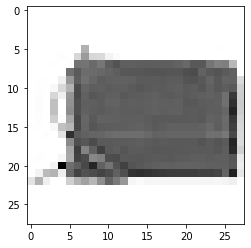

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Ankle boot: 0.000
	T-shirt/top: 0.000


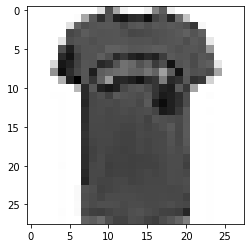

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 1.000
	Sneaker: 0.000
	Shirt: 0.000


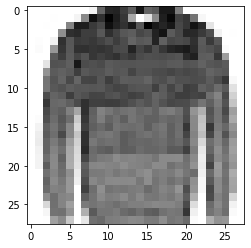

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	Coat: 0.000
	Shirt: 0.000


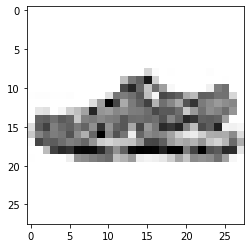

True label: Sandal
Top 3 predictions:
	Sandal: 0.999
	Sneaker: 0.001
	Bag: 0.000


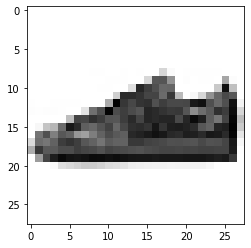

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Bag: 0.000
	Ankle boot: 0.000


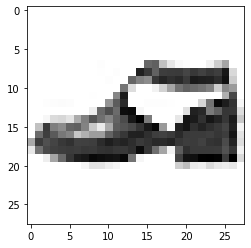

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.665
	Ankle boot: 0.333
	Sneaker: 0.001


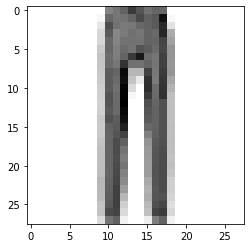

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Ankle boot: 0.000


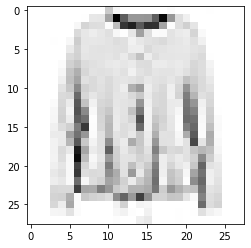

True label: Coat
Top 3 predictions:
	Shirt: 0.535
	Pullover: 0.338
	Coat: 0.106


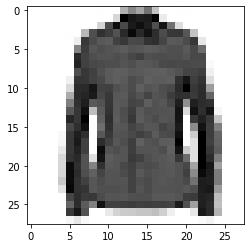

True label: Shirt
Top 3 predictions:
	Shirt: 0.995
	Pullover: 0.003
	Coat: 0.001


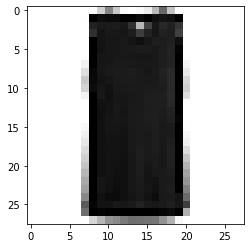

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.672
	Shirt: 0.328
	Dress: 0.000


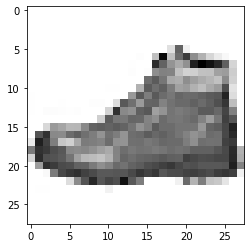

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sneaker: 0.000
	Bag: 0.000


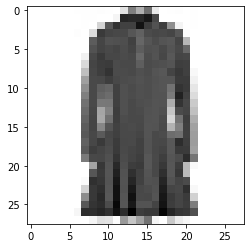

True label: Dress
Top 3 predictions:
	Dress: 0.993
	Shirt: 0.005
	Pullover: 0.002


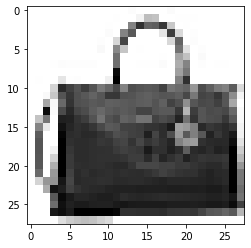

True label: Bag
Top 3 predictions:
	Bag: 1.000
	T-shirt/top: 0.000
	Ankle boot: 0.000


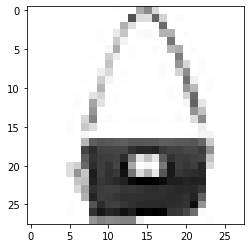

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Dress: 0.000


In [38]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Conclusion

In this notebook, we switched from a fully-connected architecture to a convolutional one, which significantly increased the efficiency of the neural network. We also made sure that adding batchnorm, pooling and dropout layers can increase the training speed and reduce the amount of network weights.